# Ultrasound breast imaging with Forge

In this notebook we solve the forward problem, generating true synthetic ultrasound for the 2D Anastasio breast model. 

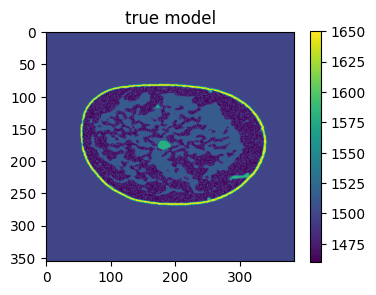

In [1]:
import numpy as np

# load the 2D anastasio breast model and set a water starting model
m = np.load('./data/anastasio2D.npy')
m0 = np.empty_like(m)
m0[:,:] = 1500

import matplotlib.pyplot as plt

# plot the true model
plt.figure(figsize=(4,3))
plt.imshow(m)
plt.title('true model')
plt.colorbar()
plt.show()

In [2]:
# load the transducer geometry
r_geometry = np.load('./data/geometry.npy')
s_geometry = r_geometry.copy()

In [3]:
from forge.utils import interpolate_models

frequency = 5e5

# interpolate models to required grid-spacing dxi
dxi, mi, m0i, r_posi, s_posi, _, _ = interpolate_models(m, m0, r_geometry, s_geometry, dx=5e-4, frequency=frequency)

# set the temporal increment, dt, to be small enough to meet the CFL condition for numerical stability
courant = 0.61
dt = (courant*dxi)/max(mi.max(), m0i.max())

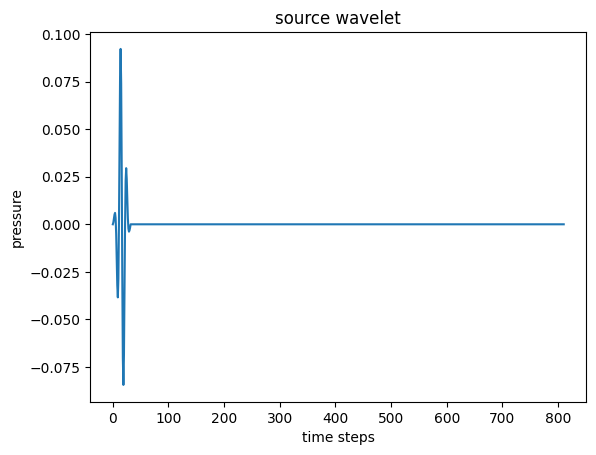

In [4]:
from forge.utils import tone_burst

time = 0.00015

# define the source wavelet 
source = tone_burst(dt, centre_freq=frequency, n_cycles=3, n_samples=round(time/dt), amplitude=1e-1, plot=True)

In [5]:
from forge.main import WaveInversion

# instantiate a Forge WaveformInversion_2d class
true_model = WaveInversion(model = mi, # true model
                           dx = dxi, # spatial increment
                           dt = dt, # temporal increment
                           r_pos = r_posi, # receiver positions
                           sampling_rate=len(source))

# configure the source positions and source wavelet
true_model.configure(s_posi, source)

# forward modelling 
true_model.forward()

device = cuda:0


100%|█████████████████████| 811/811 [01:06<00:00, 12.13it/s]


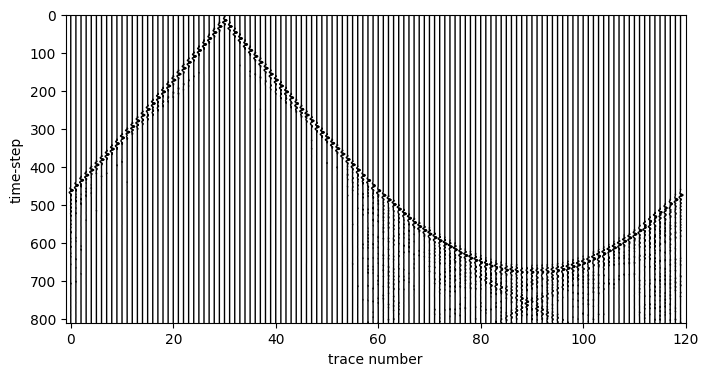

In [6]:
# save the true modelled data
np.save('./data/d.npy', true_model.d.numpy())

from forge.utils import trace_plot, trace_normalize

# visualize traces of true modelled data
trace_plot(trace_normalize(true_model.d), 30)